In [1]:
import sys
sys.path.append(r'/home/martinha/propythia/propythia/src/propythia/')
sys.path.append(r'/home/martinha/propythia/propythia/src/')

# Quickstart building and using Word Embeddings with Propythia

This notebook intends to go over the building and application of Word embedding vectors to describe biological sequences. The notebook uses protein sequences but the same principle may be used for DNA sequences. 

The Python module Bumblebee was developed for processing biological sequences aiming to search for semantic
meaning in sequence ”words” (such as nucleotides and amino
acids). This module was then integrated in ProPythia. It is organized in sub-modules so that
the user can use them in different specific tasks and adapt
them to fit the problem that is working on. The user can set
specific values for the majority of the parameters, but default
values are established. 


This include: 

    1) Read sequence sub-module: To read and/or change sequences. This is especially important to replace nonrelevant/not-common AAs simplifying the vocabulary.
    
    2) Sequence processing sub-module: To generate subsequences; Implements the segmentation of sequences by grams of size n and overlapping (or not) method.
    
    3) Create vocabulary list sub-module: To get all the vocabulary in the dataset, necessary to train the WE.
    It allows to fetch a list of n-grams from pre-existing JSON file or create the list if it is not present.
    
    4) Training word embedding models sub-module: To train and save WE models; It is possible to train W2V
    and FastText models with both CBOW or SG algorithms (based on gensim library). 
    
    5) Load models list sub-module: To load a pre-trained embedding model;
    
    6) Protein Vector representation sub-module: To get a vector representation of a sequence or the matrix of
    vectors accordingly to a model. It obtains a vector for a given n-gram and the number of occurrences of that
    n-gram. Three methods of representing sequences as vectors are implemented as described above.
    
    7) Interpretability sub-module: To visualize WE in space and get similarities between vectors. It uses t-SNE to
    create plots related to physicochemical properties of individual AA, including charge, volume, mass, Van der Waals Volume, polarity and hydrophobicity. For ngrams larger than 1, mean values of these properties are presented as described for Asgari et al. The sub-module also includes binding free energy values for trigrams, based on experimental data. If needed, users can define additional characteristics. Additionally, the models can also retrieve scores of similarity and neighborhood of the n-grams to aid in understanding vector similarities.


Important decisions to take are: 

    Either use a pretrained WE model or train your own model. 
    
    Choose the size of the biological 'words' and the way to represent the final sequence

In [2]:
import pandas as pd
import numpy as np

# 1. Using the pretrained model Protvec to create vectors

# 1.1 Getting the data

First, lets get the data. We will use an enzyme dataset as example.
For simplification purposes we will just use the first level of EC number and delete enzymes that have more than one enzyme


In [3]:
data = pd.read_csv('./enzyme/datasets/ecpred_uniprot_uniref_90.csv')
# drop entries without sequence
data=data.dropna(subset=['sequence'])
# drop entries with ! characters
data =data[~data['sequence'].str.contains("!")]

# remove promiscue enzymes
data = data[~data['ec_number'].str.contains(';')]
#get first level
data['ec_1'] = data['ec_number'].str.split('.').str[0]

# just shuffling
data=data.sample(frac=1)

print(data.shape)
# Count occurrences of specific values in the new column
value_counts = data['ec_1'].value_counts()
print(value_counts)


(169497, 9)
2    51877
3    32939
0    22708
1    18343
6    16158
4    12639
5     8006
7     6827
Name: ec_1, dtype: int64


# 1.2 Preprocess sequences
After, we will replace not common aminoacids. Furthermore, protein sequences are of different length. Depending of the method of WE you are using, you may need to use the same length for all sequences. For comparison purposes, we are setting all sequences to a max length of 500. 

In [4]:
def transform_seq(seq, max_len):
#     
    seq1 = seq.replace('B', 'N')  # asparagine N / aspartic acid  D - asx - B
    seq2 = seq1.replace('Z', 'Q')  # glutamine Q / glutamic acid  E - glx - Z
    seq3 = seq2.replace('U',
                        'C')  # selenocisteina, the closest is the cisteine. but it is a different aminoacid . take care.
    seq4 = seq3.replace('O', 'K')  # Pyrrolysine to lysine
    seq = seq4.replace('X', '')  # unknown character eliminated
    if max_len:
        seq = seq[0:max_len]
     
        
        
    return seq


seqs = data['sequence']
max_len = 500
seqs_new = list(map(lambda seq:transform_seq(seq, max_len),seqs))


# 1.3 load the WE model
Here we will use the Protvec model. This means that we will open the WordEmbedding class with a matrix file ( Protvec). The ngram len will be 3, used in Ptotvec and the vector dim is 100. 

protvec file can be obtained at https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/JMFHTN


In [5]:
from propythia.wordembedding.word_embedding import WordEmbedding as wv

protvec_file = '/home/martinha/propythia/propythia/src/propythia/wordembedding/protVec_100d_3grams.csv'

w2v = wv(emb_matrix_file=protvec_file,
         ngram_len=3 , sequence_max_len= max_len , vectordim=100)

2023-08-19 08:32:13.859168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


WordEmbedding is running..
--MATRIX LOADED--


# 1.3 get protein vectors representations
With the WE model loaded now we will transform the sequences into vectors. 
Three methods can be used: 

    • Method 1: Substitute directly the n-grams presented in the sequence by the WE vector. Being K the dimension of the word and N the dimension of the WE vector, a sequence of size L will be represented by a final vector of
    (L − k − 1) ∗ N elements. 
    This method preserves the spatial information of the location of biological words.
    
    • Method 2: k-mer word frequencies are calculated and multiplied by the corresponding WE vectors. A sequence,
    independent of the size, will be represented by a matrix of dimensions Number of words ∗ N.
    
    • Method 3: All the vectors of Method 2 are summed to reproduce a single vector of dimension N.

Lets start with method 1. Each sequence will be represented by a vector of 498 trigrams with 100 len, this is, 498 * 100 size. 
This vector can be then flat if necessary. 
We will use just 200 seuences to simplicity purposes

In [6]:
seqs_to_consider = seqs_new[:200]

# # Initialize an empty numpy array
num_sequences = len(seqs_to_consider)  # Number of sequences
result_array = np.zeros((num_sequences, 498, 100))

# Loop through the sequences and append vectors to the array
for idx, i in enumerate(seqs_to_consider):
    vector = w2v.convert_seq2vec(method=1, sequence=i, padding = True)
    result_array[idx] = vector

print(result_array.shape)


(200, 498, 100)


Method2: Each sequence will be represented by a vector of different possible trigrams (9048) * 100 len

In [7]:
seqs_to_consider = seqs_new[:200]
seqs_vector2 = []
for i in seqs_to_consider:
    vector = w2v.convert_seq2vec(method=2, sequence=i)
    seqs_vector2.append(vector)
seqs_vector = np.array(seqs_vector2)
seqs_vector.shape

(200, 904800)

Method3: Each sequence will be represented by a vector of 100 dimension. 

In [8]:
seqs_to_consider = seqs_new[:200]

# Initialize an empty numpy array
num_sequences = len(seqs_to_consider)  # Number of sequences
result_array = np.zeros((num_sequences, 100))

# Loop through the sequences and append vectors to the array
for idx, i in enumerate(seqs_to_consider):
    vector = w2v.convert_seq2vec(method=3, sequence=i, padding = True)
    result_array[idx] = vector

print(result_array.shape)

(200, 100)


these vectors can be then used to performed ML and DL machine learning. 
Whereas resulting vectors of method 1 are more suitable for DL models, method 3 may be more suitable for shallow ML. 


# 2. Train your own WE model and create vectors


# 2.1 Segmentation of protein sequences

The first step is to decompose a protein sequence into protein words. 

To do this, one must choose the size of the ’word’ to be considered -k - and segment sequences into all the possible words. Each
sequence is scanned from beginning to end, one k-mer word at a time. 

In this step, two parameters are crucial the size of the protein word to consider and the overlapping. 

    The size of the protein word is usually between 1 and 3, larger words will produce embeddings with higher complexity and will capture more relationships between AAs. However, those will also make heavier models which require lots of memory. The number of possible k-mers is obtained by the number of combinations between the AAs (1-mer = 20, 2-mer = 400 words, 3-mer = 8000 distinct words). 

    With overlapping, the sequence is represented by consecutive and overlapping windows of k size. In non-overlapping mode, a protein sequence is composed of k lists of shifted non-overlapping words. 
    
All possible words constitute the vocabulary. All the protein sequences segmented in words constitute the corpus.

## 2.1.1 Instanciate the WordEmbedding class with parameters
The parameters to train the Word Embedding model need to be defined. In this example: 

The class has parameters: 


        :param model_file: Pre-trained embedding model
        :param overlooping: True = Ngram segmentation using overlaping. False = Ngram segmentation using non-overlaping
        :param w2v:Training architecture: 1 for word2vec; otherwise fastText.
        :param sg:Training algorithm: 1 for skip-gram; otherwise CBOW.
        :param vectordim: Dimensionality of the word vectors.
        :param ngram_len: Length of the ngram
        :param AA_substitute: True = remove all of X amino acids and replace all amino acids B, Z, U and O for N, Q, C and Q.
        :param sequence_max_len: Maximum length of the biological sequence
        :param emb_matrix_file: Pre-trained embedding matrix in a .csv file
        :param windowsize: Maximum distance between the current and predicted word within a sentence
        :param filename: Given name to any files created in this class, no matter what extension

        
In this case 

    1.   model architecture  **word2vec**  
    2.   algorithm **skip-gram**  
    3.  vector dimension **100**
    4.  *n*-gram size **1**
    5.   windows size **5**



In [9]:
from propythia.wordembedding.word_embedding import WordEmbedding as wv

# w2v = wv(w2v=1, sg=1 , vectordim=100 , ngram_len= 1 ,windowsize=5)

# 2.1.2 Obtain the ngrams for training
Obtaining the *n*-grams of protein sequences to test the WE model. The overlapping would be accordingly to defined above (default is True). 

We will use the enzyme sequences to train the WE model. 

In [10]:
# select only positive seqeunces. this is, ONLYENZYMES
positive = data[data['ec_1'] != 0]
seqs_train = positive ['sequence']

w2v_sequeces = w2v.sequence_preparation(filename = None, list_of_sequences = seqs_train)

# 2.1.3 Train of the WE model 
Training the WE model in order to obtain the representating vectors fo ngrams.
The function will Train, save and set a new word embedding model using a specific method.
The inputs are: 


        :param seqs_tokenized: Sequences that mus be already tokenized.
        :param filename: Given name to any files created in this method, no matter what extension.

        Parameters with default
        :param save_csv_matrix: True if you want to save the embedding matrix in a .csv file. defaults True
        :param epochs: Number of iterations (epochs) over the corpus. Defaults 10 


        # parameters that can be set in this function or the ones defined when oppening the CLass
        :param w2v: Training architecture: 1 for word2vec; otherwise fastText.
        :param ngramlist: vocabulary - set list of ngrams.
        :param sg: Training algorithm: 1 for skip-gram; otherwise CBOW.
        :param windowsize: Maximum distance between the current and predicted word within a sentence.

        
        
        
        :return: word embedding vectors. .h5

In [11]:
# w2v.train_wordembedding(seqs_tokenized=w2v_sequeces, filename='w2v_sg_2gram_100dim_enzyme', epochs=10)
wordvecDict , word_vectores = w2v.train_wordembedding(seqs_tokenized=w2v_sequeces, filename='w2v_sg_2gram_100dim_enzyme', epochs=10, 
                        w2v=1, sg=1 , vectordim=50, ngram_len=3 ,windowsize=5,save_csv_matrix = True)
   

Start traning word embedding..
Word2Vec..
Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end
Model Saved
WordEmbedding Matrix Saved


A file with the vectors is stored at the indicated directory. The model is stored inside the class and you can use it for building representations. You can also acess it later through the file that has been stored. 
This matrix can also be used to open a W2v class or loaded with load function

One can use this vectors (or from pretrained models) to perform Machine and Deep learning. 

In [12]:
model = w2v.load_wv_model(file='data_processing/w2v_sg_2gram_100dim_enzyme.model')

from propythia.wordembedding.word_embedding import WordEmbedding as wv

protvec_file = 'data_processing/w2v_sg_2gram_100dim_enzyme.csv'

w2v = wv(emb_matrix_file=protvec_file,
         ngram_len=3 , sequence_max_len= max_len , vectordim=100)

Model Loaded
WordEmbedding is running..
--MATRIX LOADED--


# 3. Visualization of embeddings

Finally, is also possible to visualize the vectors of the embeddings in space. 

In [6]:
from propythia.wordembedding.tsne import ModelTsne
import matplotlib.pyplot as plt
import plotly.express as px


protvec_file = 'data_processing/w2v_sg_2gram_100dim_enzyme.csv'

w2v = wv(emb_matrix_file=protvec_file,
         ngram_len=3 , sequence_max_len= 500 , vectordim=100)

words = w2v.get_emb_matrix()
words.pop('<unk>', None)
result = words.values()
data = np.array(list(result))
ngrams = np.array(words.keys())

WordEmbedding is running..
--MATRIX LOADED--


TSNE is running..
[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 9047 samples in 0.000s...
[t-SNE] Computed neighbors for 9047 samples in 0.771s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9047
[t-SNE] Computed conditional probabilities for sample 2000 / 9047
[t-SNE] Computed conditional probabilities for sample 3000 / 9047
[t-SNE] Computed conditional probabilities for sample 4000 / 9047
[t-SNE] Computed conditional probabilities for sample 5000 / 9047
[t-SNE] Computed conditional probabilities for sample 6000 / 9047
[t-SNE] Computed conditional probabilities for sample 7000 / 9047
[t-SNE] Computed conditional probabilities for sample 8000 / 9047
[t-SNE] Computed conditional probabilities for sample 9000 / 9047
[t-SNE] Computed conditional probabilities for sample 9047 / 9047
[t-SNE] Mean sigma: 0.808160
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.832512
[t-SNE] KL divergence after 1000 iterations: 1.801886
Visualization


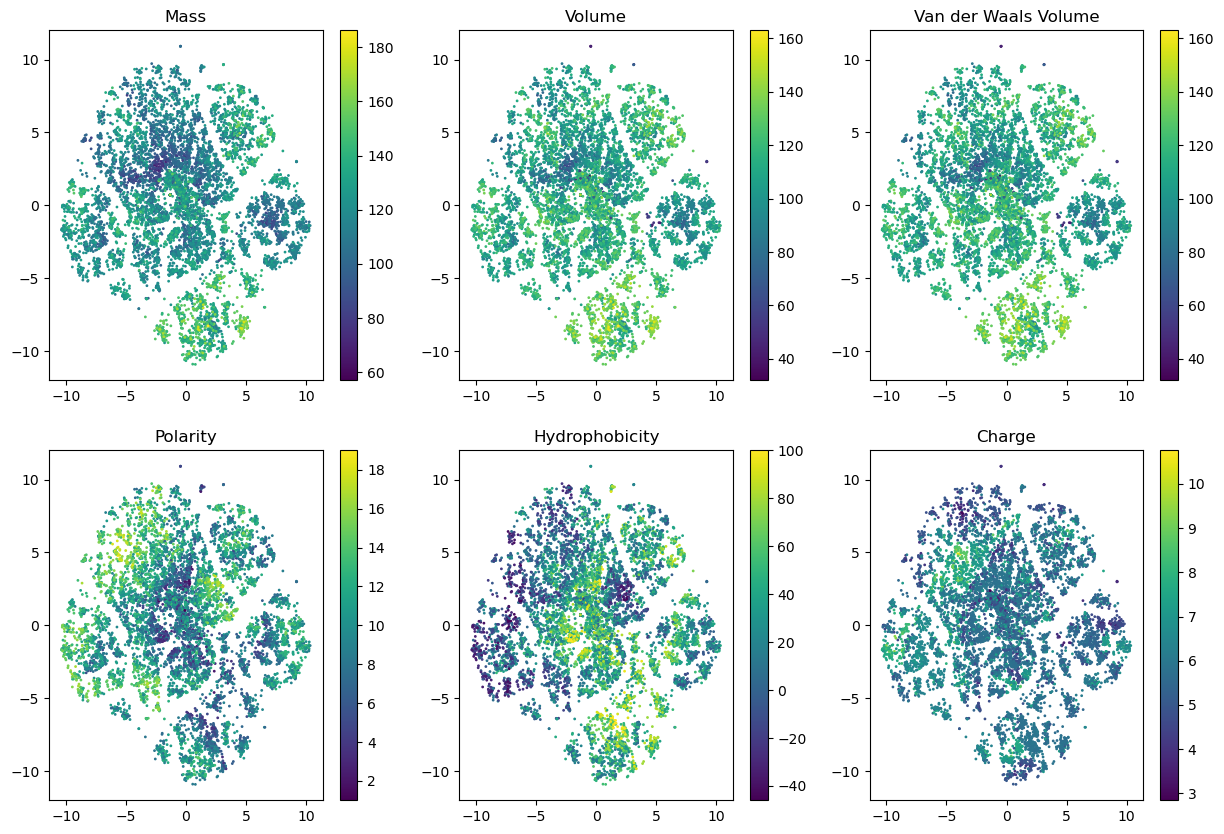

In [7]:
tsne = ModelTsne()
tsne_fit = tsne.make_tsne(data) # equivalent to tsne fit transform from scikit learn 

ngrams = list(words.keys())
ngram_properties_protvec = np.array(tsne.calculate_property(ngrams)) # calculates the properties from Protvec

tsne.visualization(tsne_fit, ngram_properties_protvec,  filename='')  # Visualization of the tsne from the 6 Protvec attributes

# for any other labels of choose 
It is also possible to use any other labels and procude a single plot. Here, we will upload the free energy calculated experimentally for tripeptides ( https://onlinelibrary.wiley.com/doi/full/10.1002/fsn3.2253) 

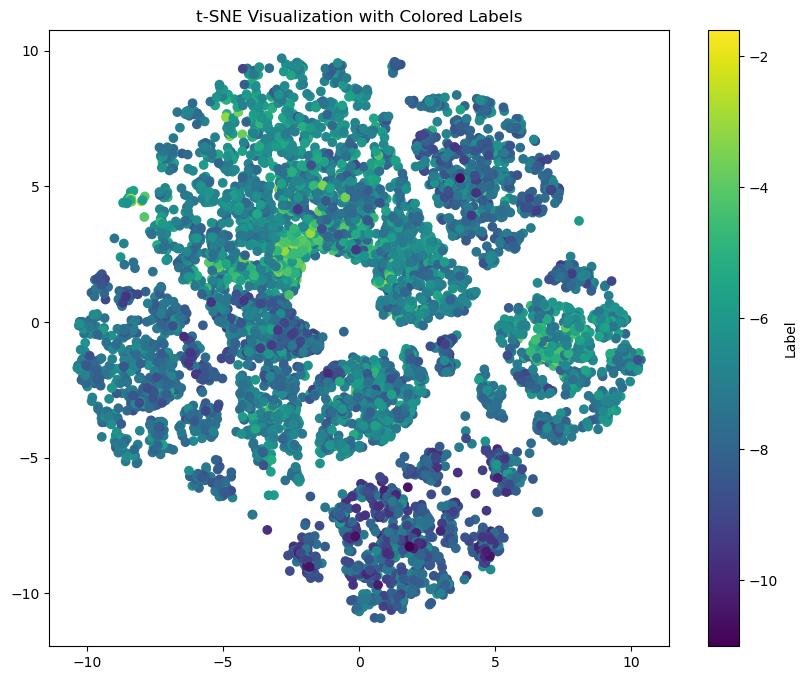

In [10]:
# for free energy 

free_energy = '/home/martinha/propythia/propythia/src/propythia/wordembedding/trigram_free_energy.csv'
df_tri = pd.read_csv(free_energy, index_col=[0], names=['ngram', 'value'])

# get the trigrams. there are no labels for all of the trigrams
ngrams = list(words.keys())
ngrams = pd.DataFrame(ngrams, columns=['ngram'])
df1 = ngrams.merge(df_tri, how='outer', on='ngram')
labels = list(df1['value'])


# Create a scatter plot with colored labels and a colorbar
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_fit[:, 0], tsne_fit[:, 1], c=labels, cmap='viridis')
plt.colorbar(scatter, label='Label')
plt.title("t-SNE Visualization with Colored Labels")
plt.show()

# for protvec

WordEmbedding is running..
--MATRIX LOADED--
TSNE is running..
[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 9047 samples in 0.001s...
[t-SNE] Computed neighbors for 9047 samples in 0.578s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9047
[t-SNE] Computed conditional probabilities for sample 2000 / 9047
[t-SNE] Computed conditional probabilities for sample 3000 / 9047
[t-SNE] Computed conditional probabilities for sample 4000 / 9047
[t-SNE] Computed conditional probabilities for sample 5000 / 9047
[t-SNE] Computed conditional probabilities for sample 6000 / 9047
[t-SNE] Computed conditional probabilities for sample 7000 / 9047
[t-SNE] Computed conditional probabilities for sample 8000 / 9047
[t-SNE] Computed conditional probabilities for sample 9000 / 9047
[t-SNE] Computed conditional probabilities for sample 9047 / 9047
[t-SNE] Mean sigma: 0.366135
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.911034
[t-SNE] KL divergence after

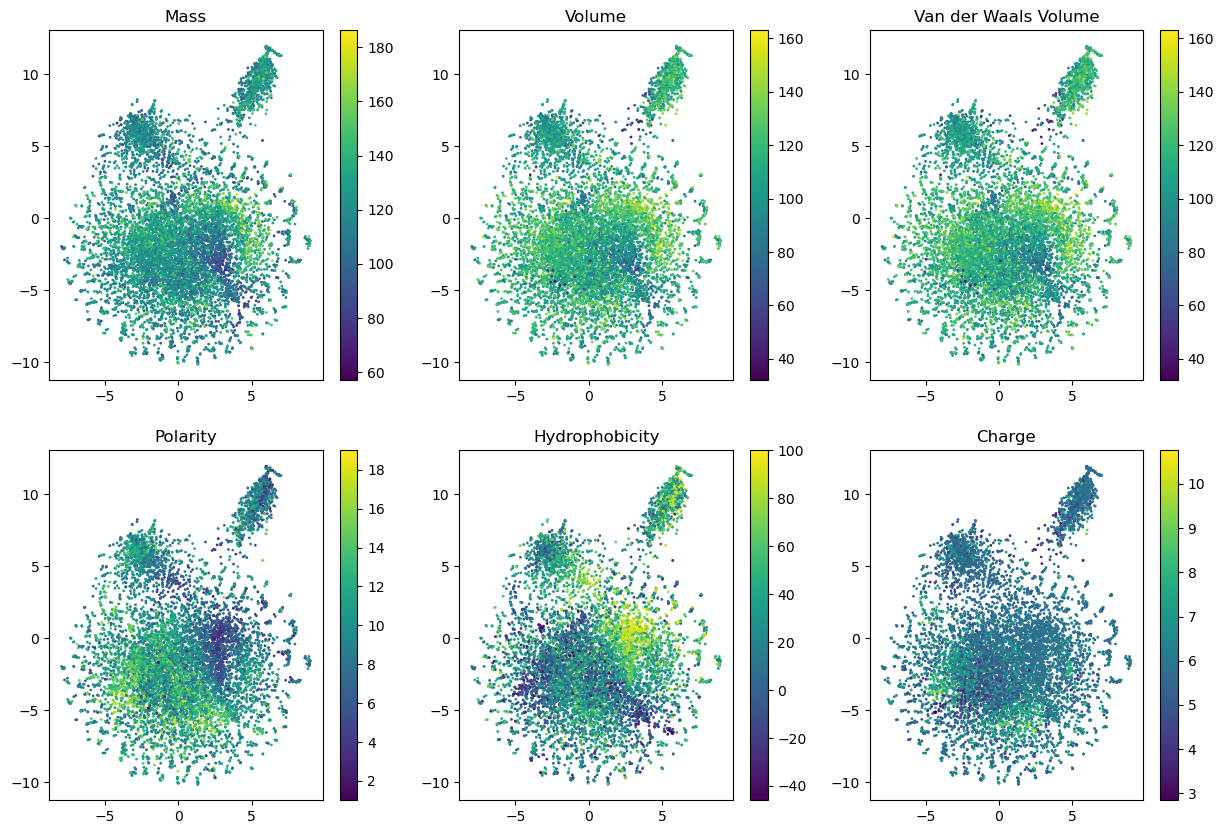

In [13]:
protvec_file = '/home/martinha/propythia/propythia/src/propythia/wordembedding/protVec_100d_3grams.csv'

w2v = wv(emb_matrix_file=protvec_file,
         ngram_len=3 , sequence_max_len= max_len , vectordim=100)

words = w2v.get_emb_matrix()
words.pop('<unk>', None)
result = words.values()
data = np.array(list(result))

ngrams = np.array(words.keys())

tsne = ModelTsne()
tsne_fit = tsne.make_tsne(data)

ngrams = list(words.keys())
ngram_properties_protvec = np.array(tsne.calculate_property(ngrams))
tsne.visualization(tsne_fit, ngram_properties_protvec,  filename='')

Fo binding free energy

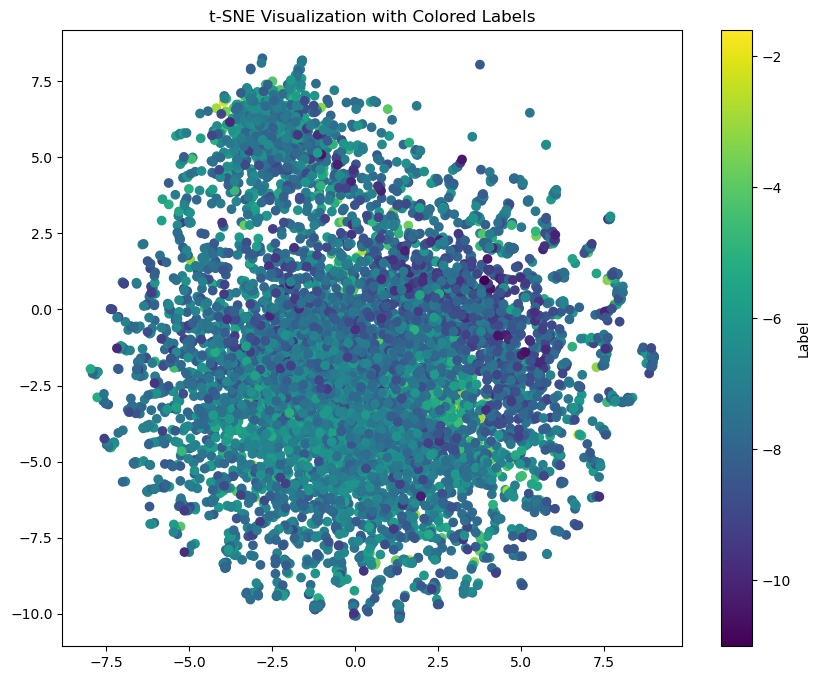

In [14]:
# get the trigrams. there are no labels for all of the trigrams
ngrams = list(words.keys())
ngrams = pd.DataFrame(ngrams, columns=['ngram'])
df1 = ngrams.merge(df_tri, how='outer', on='ngram')
labels = list(df1['value'])


# Create a scatter plot with colored labels and a colorbar
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_fit[:, 0], tsne_fit[:, 1], c=labels, cmap='viridis')
plt.colorbar(scatter, label='Label')
plt.title("t-SNE Visualization with Colored Labels")
plt.show()